<a href="https://colab.research.google.com/github/Oualidu/tensorflow-course-6-regression/blob/main/TensorFlow_Course_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Based on the TensFlow course : https://www.tensorflow.org/tutorials/keras/regression
# Modified by Mehdi Ammi, Univ. Paris 8

# TensorFlow: Regression for Predictive Modeling

In regression tasks, the goal is to forecast the output of a continuous variable, such as a price or a probability. This differs from classification problems, where the objective is to choose a class from a set of classes (for instance, identifying whether a picture shows an apple or an orange).

This tutorial employs the renowned Auto MPG dataset to illustrate how to construct models to predict the fuel efficiency of cars from the late 1970s and early 1980s. You will provide the models with detailed information about numerous cars from that era, including attributes like cylinders, displacement, horsepower, and weight.

We'll utilize the Keras API in this example. (Refer to the Keras tutorials and guides for more information.)

## Install packages & import libraries

In [ ]:
# Install the seaborn library for data visualization.
!pip install -q seaborn

In [ ]:
# Import libraries for plotting, numerical operations, data manipulation, and visualization.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set NumPy print options for better readability.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# Import TensorFlow and Keras for building neural networks.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Print the TensorFlow version.
print(tf.__version__)

## The Auto MPG dataset

The dataset is available from the UCI Machine Learning Repository.

### Get the data
First download and import the dataset using pandas:

In [ ]:
# URL of the dataset to be loaded.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

# Define the column names for the dataset.
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

# Load the dataset from the URL, specifying column names, handling missing values, and removing comments.
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

# Create a copy of the dataset for further manipulation and analysis.
dataset = raw_dataset.copy()

# Display the last few rows of the dataset.
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


|index|MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model Year|Origin|
|---|---|---|---|---|---|---|---|---|
|393|27\.0|4|140\.0|86\.0|2790\.0|15\.6|82|1|
|394|44\.0|4|97\.0|52\.0|2130\.0|24\.6|82|2|
|395|32\.0|4|135\.0|84\.0|2295\.0|11\.6|82|1|
|396|28\.0|4|120\.0|79\.0|2625\.0|18\.6|82|1|
|397|31\.0|4|119\.0|82\.0|2720\.0|19\.4|82|1|

### Clean the data

The dataset has a few missing values:

In [ ]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


Drop those rows to keep this initial tutorial simple:

In [ ]:
dataset = dataset.dropna()

The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values in the column with pd.get_dummies.

In [ ]:
# Map the values in the 'Origin' column to country labels.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Convert the 'Origin' column to indicator variables (one-hot encoding).
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

# Display the last few rows of the dataset.
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


|index|MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model Year|Europe|Japan|USA|
|---|---|---|---|---|---|---|---|---|---|---|
|393|27\.0|4|140\.0|86\.0|2790\.0|15\.6|82|false|false|true|
|394|44\.0|4|97\.0|52\.0|2130\.0|24\.6|82|true|false|false|
|395|32\.0|4|135\.0|84\.0|2295\.0|11\.6|82|false|false|true|
|396|28\.0|4|120\.0|79\.0|2625\.0|18\.6|82|false|false|true|
|397|31\.0|4|119\.0|82\.0|2720\.0|19\.4|82|false|false|true|

### Split the data into training and testing sets

Now, split the dataset into a training set and a test set:

In [ ]:
# Sample 80% of the data to create the training dataset.
train_dataset = dataset.sample(frac=0.8, random_state=0)

# Use the remaining 20% of the data to create the testing dataset.
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

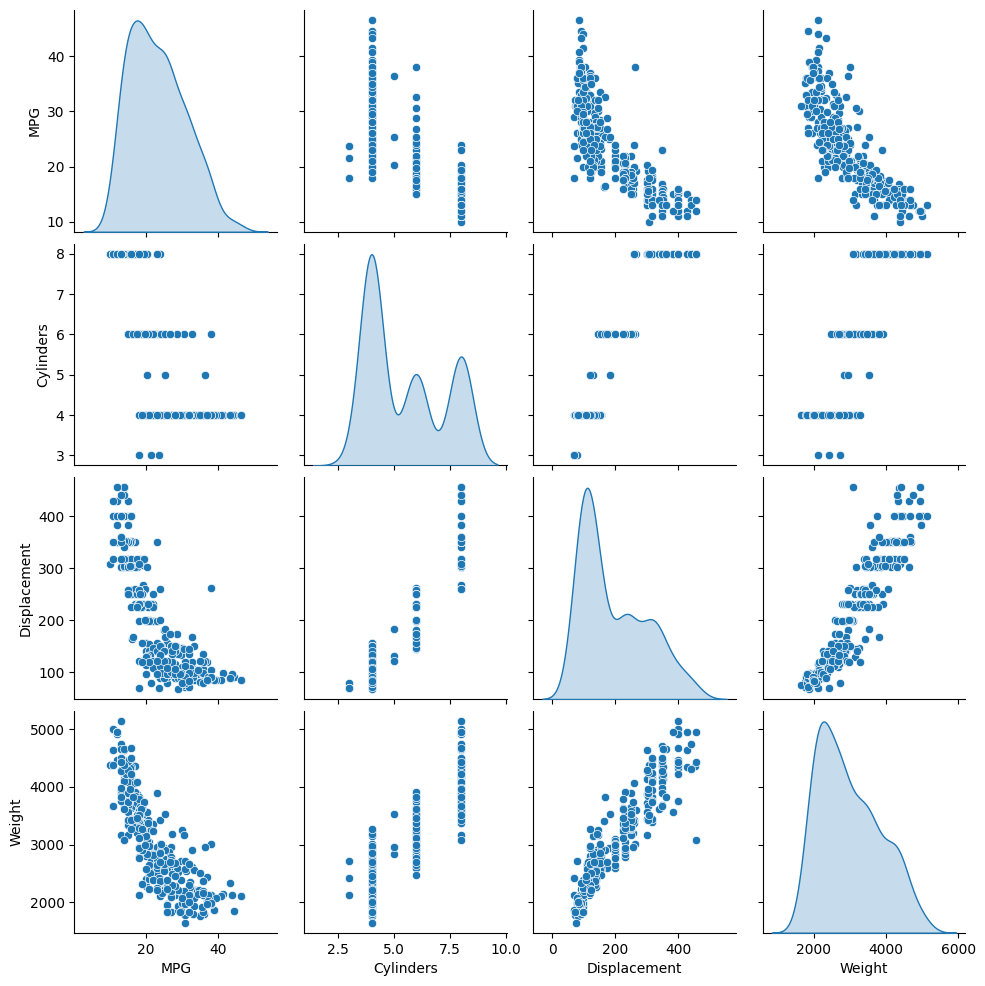

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

![reg_plot-1.png](attachment:6f28749a-fc9b-4111-a335-dc9e39050bd1.png)

Let's also check the overall statistics. Note how each feature covers a very different range:

train_dataset.describe().transpose()

|index|count|mean|std|min|25%|50%|75%|max|
|---|---|---|---|---|---|---|---|---|
|MPG|318\.0|23\.590566037735847|7\.913617162025714|10\.0|17\.125|22\.75|29\.0|46\.6|
|Cylinders|318\.0|5\.427672955974843|1\.6829413919287102|3\.0|4\.0|4\.0|6\.0|8\.0|
|Displacement|318\.0|193\.06132075471697|103\.8127417257744|70\.0|100\.25|151\.0|259\.5|455\.0|
|Horsepower|313\.0|104\.06709265175719|38\.67466171160924|46\.0|75\.0|92\.0|120\.0|230\.0|
|Weight|318\.0|2963\.8238993710693|844\.7498054897484|1613\.0|2219\.25|2792\.5|3571\.25|5140\.0|
|Acceleration|318\.0|15\.595911949685535|2\.796282280384398|8\.0|13\.9|15\.5|17\.3|24\.8|
|Model Year|318\.0|75\.94654088050315|3\.7052657537475624|70\.0|73\.0|76\.0|79\.0|82\.0|

### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [ ]:
# Create a copy of the training and testing datasets to separate features and labels.
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Remove the target variable 'MPG' from the features dataset and store it separately as labels.
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


|index|mean|std|
|---|---|---|
|MPG|23\.590566037735847|7\.913617162025714|
|Cylinders|5\.427672955974843|1\.6829413919287102|
|Displacement|193\.06132075471697|103\.8127417257744|
|Horsepower|104\.06709265175719|38\.67466171160924|
|Weight|2963\.8238993710693|844\.7498054897484|
|Acceleration|15\.595911949685535|2\.796282280384398|
|Model Year|75\.94654088050315|3\.7052657537475624|

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

### The Normalization layer

The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [ ]:
# Convert train_features to a NumPy array with dtype float32 before adapting the normalizer.
train_features_array = np.array(train_features, dtype=np.float32)

# Adapt the normalizer to the training features.
normalizer.adapt(train_features_array)

Calculate the mean and variance, and store them in the layer:

In [ ]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [ ]:
# Convert boolean columns to float (0.0 and 1.0)
train_features = train_features.astype(float)

# Extract the first row of the training features as a NumPy array with dtype float32.
first = np.array(train_features[:1], dtype=np.float32)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable
Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

 - Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
 - Apply a linear transformation (y = mx + b) to produce 1 output using a linear layer (tf.keras.layers.Dense).

The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the 'Horsepower' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:

In [ ]:
# Extract the 'Horsepower' column from the training features as a NumPy array.
horsepower = np.array(train_features['Horsepower'])

# Create a Normalization layer for normalizing the 'Horsepower' data.
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)

# Adapt the normalization layer to the 'Horsepower' data, calculating the mean and variance.
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Build the Keras Sequential model:

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

horsepower_model.predict(horsepower[:10])

Once the model is built, configure the training procedure using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).

In [ ]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras Model.fit to execute the training for 100 epochs:

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 12.9 s, sys: 330 ms, total: 13.2 s
Wall time: 22.5 s


Visualize the model's training progress using the stats stored in the history object:

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803034,4.172861,95
96,3.806053,4.181260,96
97,3.809597,4.210390,97
98,3.804358,4.184638,98
99,3.808040,4.190637,99


|index|loss|val\_loss|epoch|
|---|---|---|---|
|95|3\.803338050842285|4\.1811957359313965|95|
|96|3\.802067279815674|4\.20026969909668|96|
|97|3\.803834915161133|4\.194756507873535|97|
|98|3\.811049222946167|4\.185152530670166|98|
|99|3\.8024814128875732|4\.211414337158203|99|

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

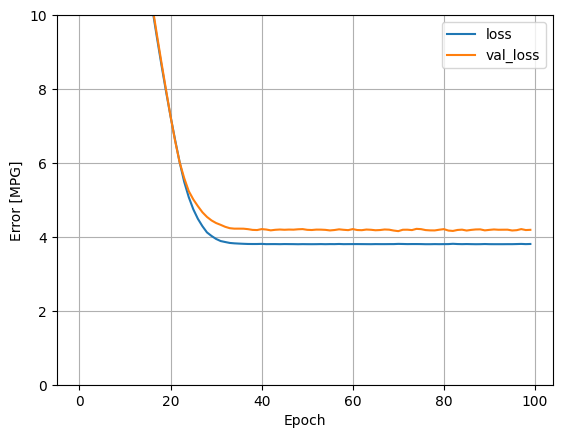

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

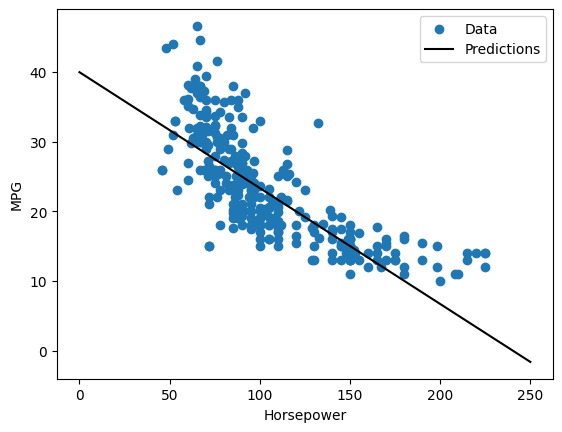

In [ ]:
plot_horsepower(x, y)

### Linear regression with multiple inputs
You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same
y=mx+b except that m is a matrix and x is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call Model.predict on a batch of inputs, it produces units=1 outputs for each example:

In [ ]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


array([[-2.245],
       [-0.366],
       [ 2.773],
       [-1.269],
       [-1.464],
       [ 0.718],
       [-1.694],
       [-0.293],
       [-0.068],
       [-1.904]], dtype=float32)

When you call the model, its weight matrices will be built—check that the kernel weights (the m in y=mx+b) have a shape of (9, 1):

In [ ]:
linear_model.layers[1].kernel

<Variable path=sequential_7/dense_8/kernel, shape=(9, 1), dtype=float32, value=[[0.321]
 [0.675]
 [0.596]
 [0.568]
 [0.176]
 [0.483]
 [0.163]
 [0.222]
 [0.35 ]]>

Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 10.8 s, sys: 351 ms, total: 11.1 s
Wall time: 11.4 s


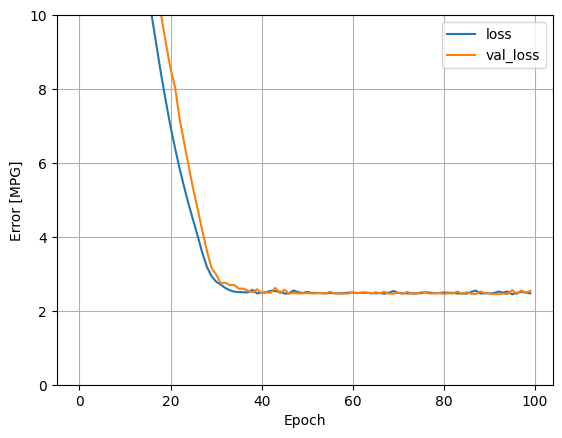

In [ ]:
plot_loss(history)

*plot_loss*(history)

Collect the results on the test set for later:

In [ ]:
# Ensure all features are converted to float32 to be compatible with TensorFlow.
test_features = test_features.astype(np.float32)

# Evaluate the model on the test dataset and store the results.
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

 - The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model).
 - Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
 - A linear Dense single-output layer.

Both models will use the same training procedure, so the compile method is included in the build_and_compile_model function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only 'Horsepower' as input and horsepower_normalizer (defined earlier) as the normalization layer:

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [ ]:
dnn_horsepower_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras Model.fit:

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 11.6 s, sys: 412 ms, total: 12 s
Wall time: 11.9 s


This model does slightly better than the linear single-input horsepower_model:

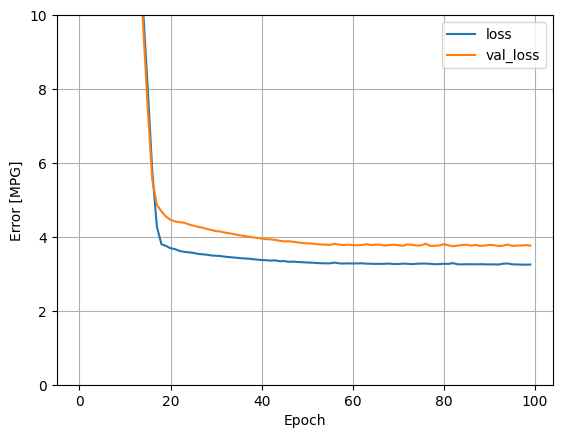

In [ ]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


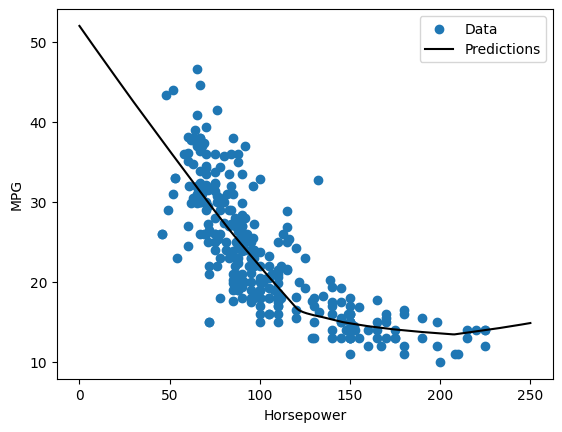

In [ ]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
dnn_model = build_and_compile_model(normalizer)


%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 11.5 s, sys: 446 ms, total: 11.9 s
Wall time: 12.4 s


Collect the results on the test set:

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Performance

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.662477
linear_model,2.547314
dnn_horsepower_model,2.906868
dnn_model,1.676439


|index|Mean absolute error \[MPG\]|
|---|---|
|horsepower\_model|3\.651707172393799|
|linear\_model|2\.481541156768799|
|dnn\_horsepower\_model|2\.9002833366394043|
|dnn\_model|1\.683077335357666|

These results match the validation error observed during training.

### Make predictions

You can now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


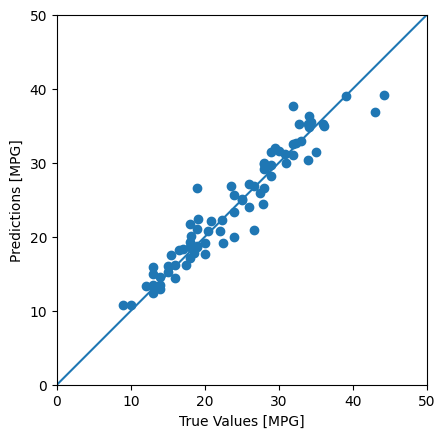

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It appears that the model predicts reasonably well.

Now, check the error distribution:

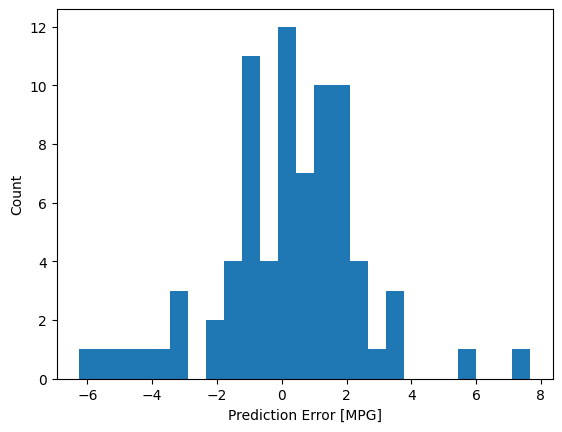

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with Model.save:

In [ ]:
dnn_model.save('dnn_model.keras')

## Exercices

### Exercise 1: Data Preprocessing

1. Load and preprocess the Auto MPG dataset, including handling missing values and one-hot encoding categorical variables.
2. Replace missing values in the 'Horsepower' column with the median value instead of dropping them.
3. Modify the one-hot encoding to include a prefix for the origin countries ('Origin_').


In [ ]:
# Exercice 1 — Data preprocessing

# On repart du dataset brut
dataset = raw_dataset.copy()

# Remplacer les valeurs manquantes de Horsepower par la médiane
mediane_hp = dataset["Horsepower"].median()
dataset["Horsepower"] = dataset["Horsepower"].fillna(mediane_hp)

# One-hot encoding de Origin avec préfixe Origin_
dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="Origin")



# Vérification
dataset.isna().sum(), dataset.head()

(MPG             0
 Cylinders       0
 Displacement    0
 Horsepower      0
 Weight          0
 Acceleration    0
 Model Year      0
 Origin_1        0
 Origin_2        0
 Origin_3        0
 dtype: int64,
     MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
 0  18.0          8         307.0       130.0  3504.0          12.0   
 1  15.0          8         350.0       165.0  3693.0          11.5   
 2  18.0          8         318.0       150.0  3436.0          11.0   
 3  16.0          8         304.0       150.0  3433.0          12.0   
 4  17.0          8         302.0       140.0  3449.0          10.5   
 
    Model Year  Origin_1  Origin_2  Origin_3  
 0          70      True     False     False  
 1          70      True     False     False  
 2          70      True     False     False  
 3          70      True     False     False  
 4          70      True     False     False  )

### Exercise 2: Single-Variable Linear Regression

1. Create and train a single-variable linear regression model to predict 'MPG' from 'Horsepower'.
2. Use 'Weight' as the single feature for prediction instead of 'Horsepower'.
3. Change the optimizer from 'Adam' to 'SGD' with a learning rate of 0.01 and retrain the model.


In [ ]:
# Exercise 2: Single-Variable Linear Regression

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Cible
y = dataset["MPG"]

# 1) MPG depuis Horsepower (Adam)
X = dataset[["Horsepower"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modele_hp = tf.keras.Sequential([tf.keras.layers.Dense(1)])
modele_hp.compile(optimizer="adam", loss="mse", metrics=["mae"])
modele_hp.fit(X_train, y_train, epochs=100, verbose=0)
print("MAE (Horsepower, Adam) =", modele_hp.evaluate(X_test, y_test, verbose=0)[1])

# 2) MPG depuis Weight (Adam)
X = dataset[["Weight"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modele_w = tf.keras.Sequential([tf.keras.layers.Dense(1)])
modele_w.compile(optimizer="adam", loss="mse", metrics=["mae"])
modele_w.fit(X_train, y_train, epochs=100, verbose=0)
print("MAE (Weight, Adam) =", modele_w.evaluate(X_test, y_test, verbose=0)[1])

# 3) MPG depuis Weight (SGD lr=0.01) et ré-entrainement
# (normalisation pour éviter NaN avec SGD)

normaliseur = tf.keras.layers.Normalization()
normaliseur.adapt(X_train.to_numpy())

modele_w_sgd = tf.keras.Sequential([normaliseur, tf.keras.layers.Dense(1)])
modele_w_sgd.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss="mse",
    metrics=["mae"]
)

modele_w_sgd.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=100, verbose=0)
print("MAE (Weight, SGD lr=0.01) =",
      modele_w_sgd.evaluate(X_test.to_numpy(), y_test.to_numpy(), verbose=0)[1])

MAE (Horsepower, Adam) = 61.3325309753418
MAE (Weight, Adam) = 18.205509185791016
MAE (Weight, SGD lr=0.01) = 3.1177659034729004


### Exercise 3: Multi-Variable Linear Regression

1. Create and train a linear regression model using multiple features.
2. Add an additional Dense layer with 10 units before the output layer and retrain the model.
3. Change the learning rate to 0.05 and retrain the model.


In [ ]:
# Exercise 3: Multi-Variable Linear Regression


import tensorflow as tf
from sklearn.model_selection import train_test_split

# Cible
y = dataset["MPG"]

# Variables explicatives (toutes sauf MPG)
X = dataset.drop(columns=["MPG"])

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 1 Régression linéaire multi-variables (Adam)

modele_multi = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

modele_multi.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

modele_multi.fit(X_train, y_train, epochs=100, verbose=0)
print("MAE (multi-features, Adam) =",
      modele_multi.evaluate(X_test, y_test, verbose=0)[1])



# 2 Ajout d'une couche Dense(10) avant la sortie
modele_multi_dense = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

modele_multi_dense.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

modele_multi_dense.fit(X_train, y_train, epochs=100, verbose=0)
print("MAE (Dense 10 + sortie, Adam) =",
      modele_multi_dense.evaluate(X_test, y_test, verbose=0)[1])



# 3) Même modèle avec learning rate = 0.05
modele_multi_lr = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

modele_multi_lr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    loss="mse",
    metrics=["mae"]
)

modele_multi_lr.fit(X_train, y_train, epochs=100, verbose=0)
print("MAE (Dense 10, Adam lr=0.05) =",
      modele_multi_lr.evaluate(X_test, y_test, verbose=0)[1])


MAE (multi-features, Adam) = 31.296222686767578
MAE (Dense 10 + sortie, Adam) = 6.356539726257324
MAE (Dense 10, Adam lr=0.05) = 2.4140756130218506


### Exercise 4: Deep Neural Network Regression

1. Create and train a deep neural network model using multiple features.
2. Use 3 hidden layers with 128, 64, and 32 units respectively.
3. Change the activation function of the hidden layers from 'relu' to 'tanh' and retrain the model.



In [ ]:
# Exercise 4: Deep Neural Network Regression

import tensorflow as tf
from sklearn.model_selection import train_test_split

# cible
y = dataset["MPG"]

# features (toutes sauf MPG)
X = dataset.drop(columns=["MPG"])

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Modèle DNN (relu) : 128, 64, 32
dnn_relu = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

dnn_relu.compile(optimizer="adam", loss="mse", metrics=["mae"])
dnn_relu.fit(X_train, y_train, epochs=100, verbose=0)

print("MAE (DNN relu) =", dnn_relu.evaluate(X_test, y_test, verbose=0)[1])


#  Même modèle mais activation = tanh
dnn_tanh = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="tanh", input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation="tanh"),
    tf.keras.layers.Dense(32, activation="tanh"),
    tf.keras.layers.Dense(1)
])

dnn_tanh.compile(optimizer="adam", loss="mse", metrics=["mae"])
dnn_tanh.fit(X_train, y_train, epochs=100, verbose=0)

print("MAE (DNN tanh) =", dnn_tanh.evaluate(X_test, y_test, verbose=0)[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MAE (DNN relu) = 2.277554988861084


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MAE (DNN tanh) = 5.938427925109863


### Exercise 5: Evaluating Model Performance

1. Evaluate the single-variable linear regression model on the test dataset.
2. Plot the true vs. predicted 'MPG' values for the test dataset.
3. Compute and plot the distribution of prediction errors (true values - predicted values).


MAE sur le jeu de test = 61.3325309753418


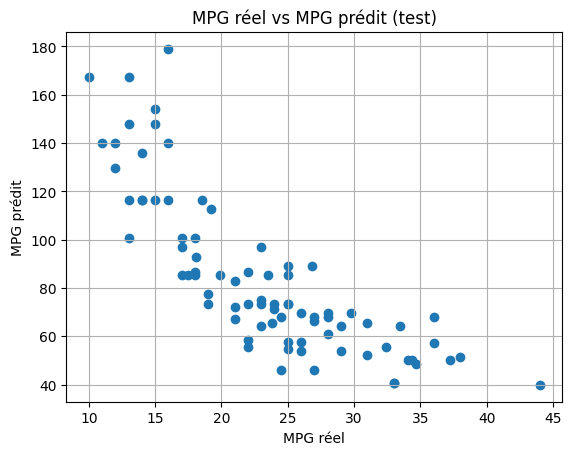

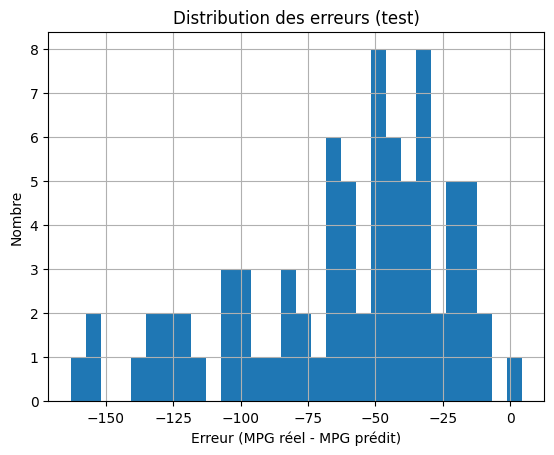

In [ ]:
# Exercise 5: Evaluating Model Performance
# (modèle 1 variable : MPG - Horsepower)



import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# On reprend la même entrée que le modèle simple : Horsepower seulement
X_hp = dataset[["Horsepower"]]
y = dataset["MPG"]

X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(
    X_hp, y, test_size=0.2, random_state=42
)

# 1 Évaluer le modèle sur le test
mae_test = modele_hp.evaluate(X_test_hp, y_test_hp, verbose=0)[1]
print("MAE sur le jeu de test =", mae_test)

# 2 Prédire sur le test
y_pred = modele_hp.predict(X_test_hp, verbose=0).flatten()

# 3) Plot vrai vs prédit
plt.figure()
plt.scatter(y_test_hp, y_pred)
plt.xlabel("MPG réel")
plt.ylabel("MPG prédit")
plt.title("MPG réel vs MPG prédit (test)")
plt.grid(True)
plt.show()

# 4 Erreurs (vrai - prédit) + histogramme
erreurs = y_test_hp.to_numpy() - y_pred

plt.figure()
plt.hist(erreurs, bins=30)
plt.xlabel("Erreur (MPG réel - MPG prédit)")
plt.ylabel("Nombre")
plt.title("Distribution des erreurs (test)")
plt.grid(True)
plt.show()

### Exercise 6: Feature Engineering

1. Add polynomial features (e.g., square and cubic terms) for 'Horsepower' to the dataset and retrain the linear regression model.
2. Implement feature scaling using Min-Max normalization instead of standard normalization and retrain the model.
3. Compare the performance of the model with polynomial features to the original linear model.


In [ ]:
# Exercise 6: Feature Engineering


import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Cible
y = dataset["MPG"]



# 1) Modèle linéaire original (Horsepower seul)

X_lin = dataset[["Horsepower"]]

X_train_lin, X_test_lin, y_train, y_test = train_test_split(
    X_lin, y, test_size=0.2, random_state=42
)

modele_lin = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])
modele_lin.compile(optimizer="adam", loss="mse", metrics=["mae"])
modele_lin.fit(X_train_lin, y_train, epochs=100, verbose=0)

mae_lin = modele_lin.evaluate(X_test_lin, y_test, verbose=0)[1]
print("MAE modèle linéaire =", mae_lin)


# 2 Ajout de features polynomiales (HP, HP², HP³)

X_poly = pd.DataFrame({
    "HP": dataset["Horsepower"],
    "HP2": dataset["Horsepower"] ** 2,
    "HP3": dataset["Horsepower"] ** 3
})

X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)


# 3) Min-Max normalization
scaler = MinMaxScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)




# 4) Modèle avec features polynomiales + Min-Max

modele_poly = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])
modele_poly.compile(optimizer="adam", loss="mse", metrics=["mae"])
modele_poly.fit(X_train_poly, y_train, epochs=100, verbose=0)

mae_poly = modele_poly.evaluate(X_test_poly, y_test, verbose=0)[1]
print("MAE modèle polynomial =", mae_poly)

MAE modèle linéaire = 14.066688537597656
MAE modèle polynomial = 22.090192794799805


### Exercise 7: Regularization

1. Add L2 regularization to the multi-variable linear regression model and retrain it.
2. Adjust the regularization strength and observe its effect on model performance and overfitting.
3. Plot the training and validation loss curves to visualize the impact of regularization.


In [ ]:
# Exercise 7: Regularization


import tensorflow as tf
from sklearn.model_selection import train_test_split

# données
X = dataset.drop(columns=["MPG"])
y = dataset["MPG"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# modèle avec régularisation L2
modele_l2 = tf.keras.Sequential([
    tf.keras.layers.Dense(
        10,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ),
    tf.keras.layers.Dense(1)
])

modele_l2.compile(optimizer="adam", loss="mse", metrics=["mae"])

history_l2 = modele_l2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    verbose=0
)

print("MAE (L2 = 0.01) =", modele_l2.evaluate(X_test, y_test, verbose=0)[1])

MAE (L2 = 0.01) = 9.312967300415039


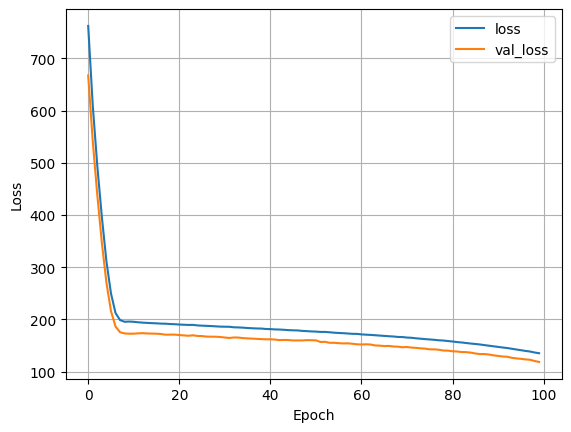

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_l2.history["loss"], label="loss")
plt.plot(history_l2.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Exercise 8: Hyperparameter Tuning

1. Perform hyperparameter tuning for the deep neural network model using Keras Tuner to find the optimal number of layers, units, and learning rate.
2. Train the model with the best hyperparameters found.
3. Compare the performance of the tuned model with the original DNN model.


In [ ]:
# Exercise 8: Hyperparameter Tuning



!pip install -q keras-tuner
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()

    # nombre de couches
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", 32, 128, step=32),
            activation="relu"
        ))

    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", [0.001, 0.01])
        ),
        loss="mse",
        metrics=["mae"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=5,
    directory="tuning",
    project_name="mpg"
)

tuner.search(X_train, y_train, validation_split=0.2, epochs=50, verbose=0)

best_model = tuner.get_best_models(1)[0]

print("MAE modèle optimisé =", best_model.evaluate(X_test, y_test, verbose=0)[1])

Reloading Tuner from tuning/mpg/tuner0.json


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


MAE modèle optimisé = 2.8812317848205566


### Exercise 9: Cross-Validation

1. Implement k-fold cross-validation for the multi-variable linear regression model.
2. Calculate the average mean absolute error (MAE) across all folds.
3. Compare the cross-validation performance to the train-test split performance.


In [ ]:
# Exercise 9: Cross-Validation

from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
maes = []

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    model = tf.keras.Sequential([tf.keras.layers.Dense(1)])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    model.fit(X_tr, y_tr, epochs=100, verbose=0)

    mae = model.evaluate(X_te, y_te, verbose=0)[1]
    maes.append(mae)

print("MAE moyenne (cross-validation) =", np.mean(maes))

MAE moyenne (cross-validation) = 73.81658897399902


### Exercise 10: Model Deployment

1. Save the trained deep neural network model to a file.
2. Load the saved model and make predictions on a new dataset.
3. Implement a simple Flask web application that accepts input features and returns the predicted 'MPG' value.

In [ ]:
# Exercise 10: Model Deployment (Save / Load / Predict)


import tensorflow as tf
import pandas as pd
import numpy as np

# 1 Sauvegarder le modèle entraîné (remplace dnn_relu par ton modèle si besoin)
dnn_relu.save("modele_mpg.keras")

# 2 Recharger le modèle
modele_charge = tf.keras.models.load_model("modele_mpg.keras")

# 3 Nouvelles données (features) -> conversion sûre en nombres + float32
X_new_df = dataset.drop(columns=["MPG"]).iloc[:3].copy()
X_new_df = X_new_df.apply(pd.to_numeric, errors="coerce")  # force en numérique
X_new = X_new_df.to_numpy(dtype=np.float32)               # float32 pour TF

pred = modele_charge.predict(X_new, verbose=0).flatten()
print("Prédictions MPG :", pred)








Prédictions MPG : [15.61  15.149 16.407]


In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
import numpy as np

app = Flask(__name__)

# charger le modèle sauvegardé
modele = tf.keras.models.load_model("modele_mpg.keras")

@app.route("/predict", methods=["POST"])
def predict():

    # on attend: {"features": [val1, val2, ..., valN]}
    features = request.json["features"]
    x = np.array(features, dtype=np.float32).reshape(1, -1)

    y_pred = modele.predict(x, verbose=0)[0][0]
    return jsonify({"mpg_predicted": float(y_pred)})



if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
